Imports

In [1]:
import os
import warnings
import time
from pathlib import Path
from glob import glob
import shutil

import numpy as np
import pandas as pd

from PIL import Image
import cv2 as cv

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import RMSprop, Adam
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch.autograd import Variable
import torch.autograd as autograd
from torch.autograd import grad
import torchvision.utils as vutils
from torchvision.utils import save_image
from torchvision import transforms, datasets
from torch.amp import autocast, GradScaler
from torch.nn import BCEWithLogitsLoss
from torch.nn.utils import spectral_norm
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
import yaml
import random


print(os.listdir("./input"))
warnings.filterwarnings("ignore")

#define some directories we will use later
YOLO_DIR = 'yolodataset'
MAPPING_TYPE={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
CLASS_NAMES = list(MAPPING_TYPE.keys())
DATSETS_DIR = 'datasets/'
OUTPUT_YAML_PATH = 'yolo_dataset.yaml'

BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')
GRAPHS_PATH = os.path.join(os.getcwd(), 'models', 'graphs')
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
DEBUG_IMAGERY_PATH = os.path.join(DATA_DIR_PATH, 'debug_imagery')

/home/david/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['DATASET.md', 'wm811k-wafer-map']


Process datset 

The overall goal here is to process and give an idea of what the data looks like before we train the WGAN-GP model later, while we are here, we will also try to tackle the issue that wm811k is very very unbalanced, there are 5000-9000 examples of some error patterns, while one error pattern has less than 200 examples, this leads to very problematic training. To combat this, we will be rotating and mirroring every sample since wafers tend to be rotation agnostic. This generates about 8 times more trainable data which doesnt eliminate the issue but helps somewhat.

Known issues:

The dataset has wafers with varying dimensions, from about 20x20 up to 300x200. I've had to just resize them all to 64x64 for training since resizing to 300x300 made training too slow. Padding smaller images up to 64 also didn't work well with the current architecture as it tended to cause fuzzy and irregular wafer edges. 

In [2]:
# Read the pickle file containing wm811k as a dataframe
# Note: Make sure you put the pickle in the correct location, you may need to edit this line

df = pd.read_pickle("./input/wm811k-wafer-map/LSWMD.pkl")
df.info()
df = df.drop(['waferIndex'], axis = 1)

def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

print(max(df.waferMapDim), min(df.waferMapDim))

print(df.info())
display(df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB
(300, 202) (6, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   trianTestLabel  811457 non-null  object 
 4   failureType     811457 non-null  object 
 5   waferMapDim  

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"


In [3]:
# relabel the data 
# several are displayed to show the relevant structure

df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
MAPPING_TYPE={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':MAPPING_TYPE, 'trainTestNum':mapping_traintest})
display(df.sample(10))

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
4697,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",533.0,lot189,[[Training]],[[none]],"(26, 26)",8,0
64838,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,...",1187.0,lot4967,[],[],"(51, 30)",[],[]
455863,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",796.0,lot28086,[],[],"(31, 33)",[],[]
756209,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 2,...",518.0,lot45294,[[Test]],[[none]],"(27, 25)",8,1
473367,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot29162,[],[],"(49, 39)",[],[]
726862,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot44106,[[Test]],[[none]],"(30, 34)",8,1
557272,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",733.0,lot34990,[],[],"(31, 31)",[],[]
629614,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1,...",515.0,lot39610,[],[],"(25, 27)",[],[]
208285,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3532.0,lot13255,[],[],"(64, 71)",[],[]
560807,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",710.0,lot35260,[],[],"(32, 29)",[],[]


In [4]:
#total number of wafers

tol_wafers = df.shape[0]
print(tol_wafers)

811457


In [5]:
# number of wafers with label, with an error pattern, with no error pattern and labeled as such

df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel = df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
print(df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0])

172950 25519 147431


In [6]:
# concat and prep dataset

df = pd.concat([df_withpattern, df_nonpattern], ignore_index=True)
print(df.info())
df["encoded_labels"] = df["failureType"].replace(MAPPING_TYPE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172950 entries, 0 to 172949
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           25519 non-null   float64
 1   waferMap        172950 non-null  object 
 2   dieSize         172950 non-null  float64
 3   lotName         172950 non-null  object 
 4   trianTestLabel  172950 non-null  object 
 5   failureType     172950 non-null  object 
 6   waferMapDim     172950 non-null  object 
 7   failureNum      172950 non-null  object 
 8   trainTestNum    172950 non-null  object 
dtypes: float64(2), object(7)
memory usage: 11.9+ MB
None


In [7]:
# number of samples by label
failure_counts = df['failureType'].value_counts()
print(failure_counts)

dfs = {failure_num: group.head(12000) for failure_num, group in df.groupby('failureNum')}

failureType
[[none]]         147431
[[Edge-Ring]]      9680
[[Edge-Loc]]       5189
[[Center]]         4294
[[Loc]]            3593
[[Scratch]]        1193
[[Random]]          866
[[Donut]]           555
[[Near-full]]       149
Name: count, dtype: int64


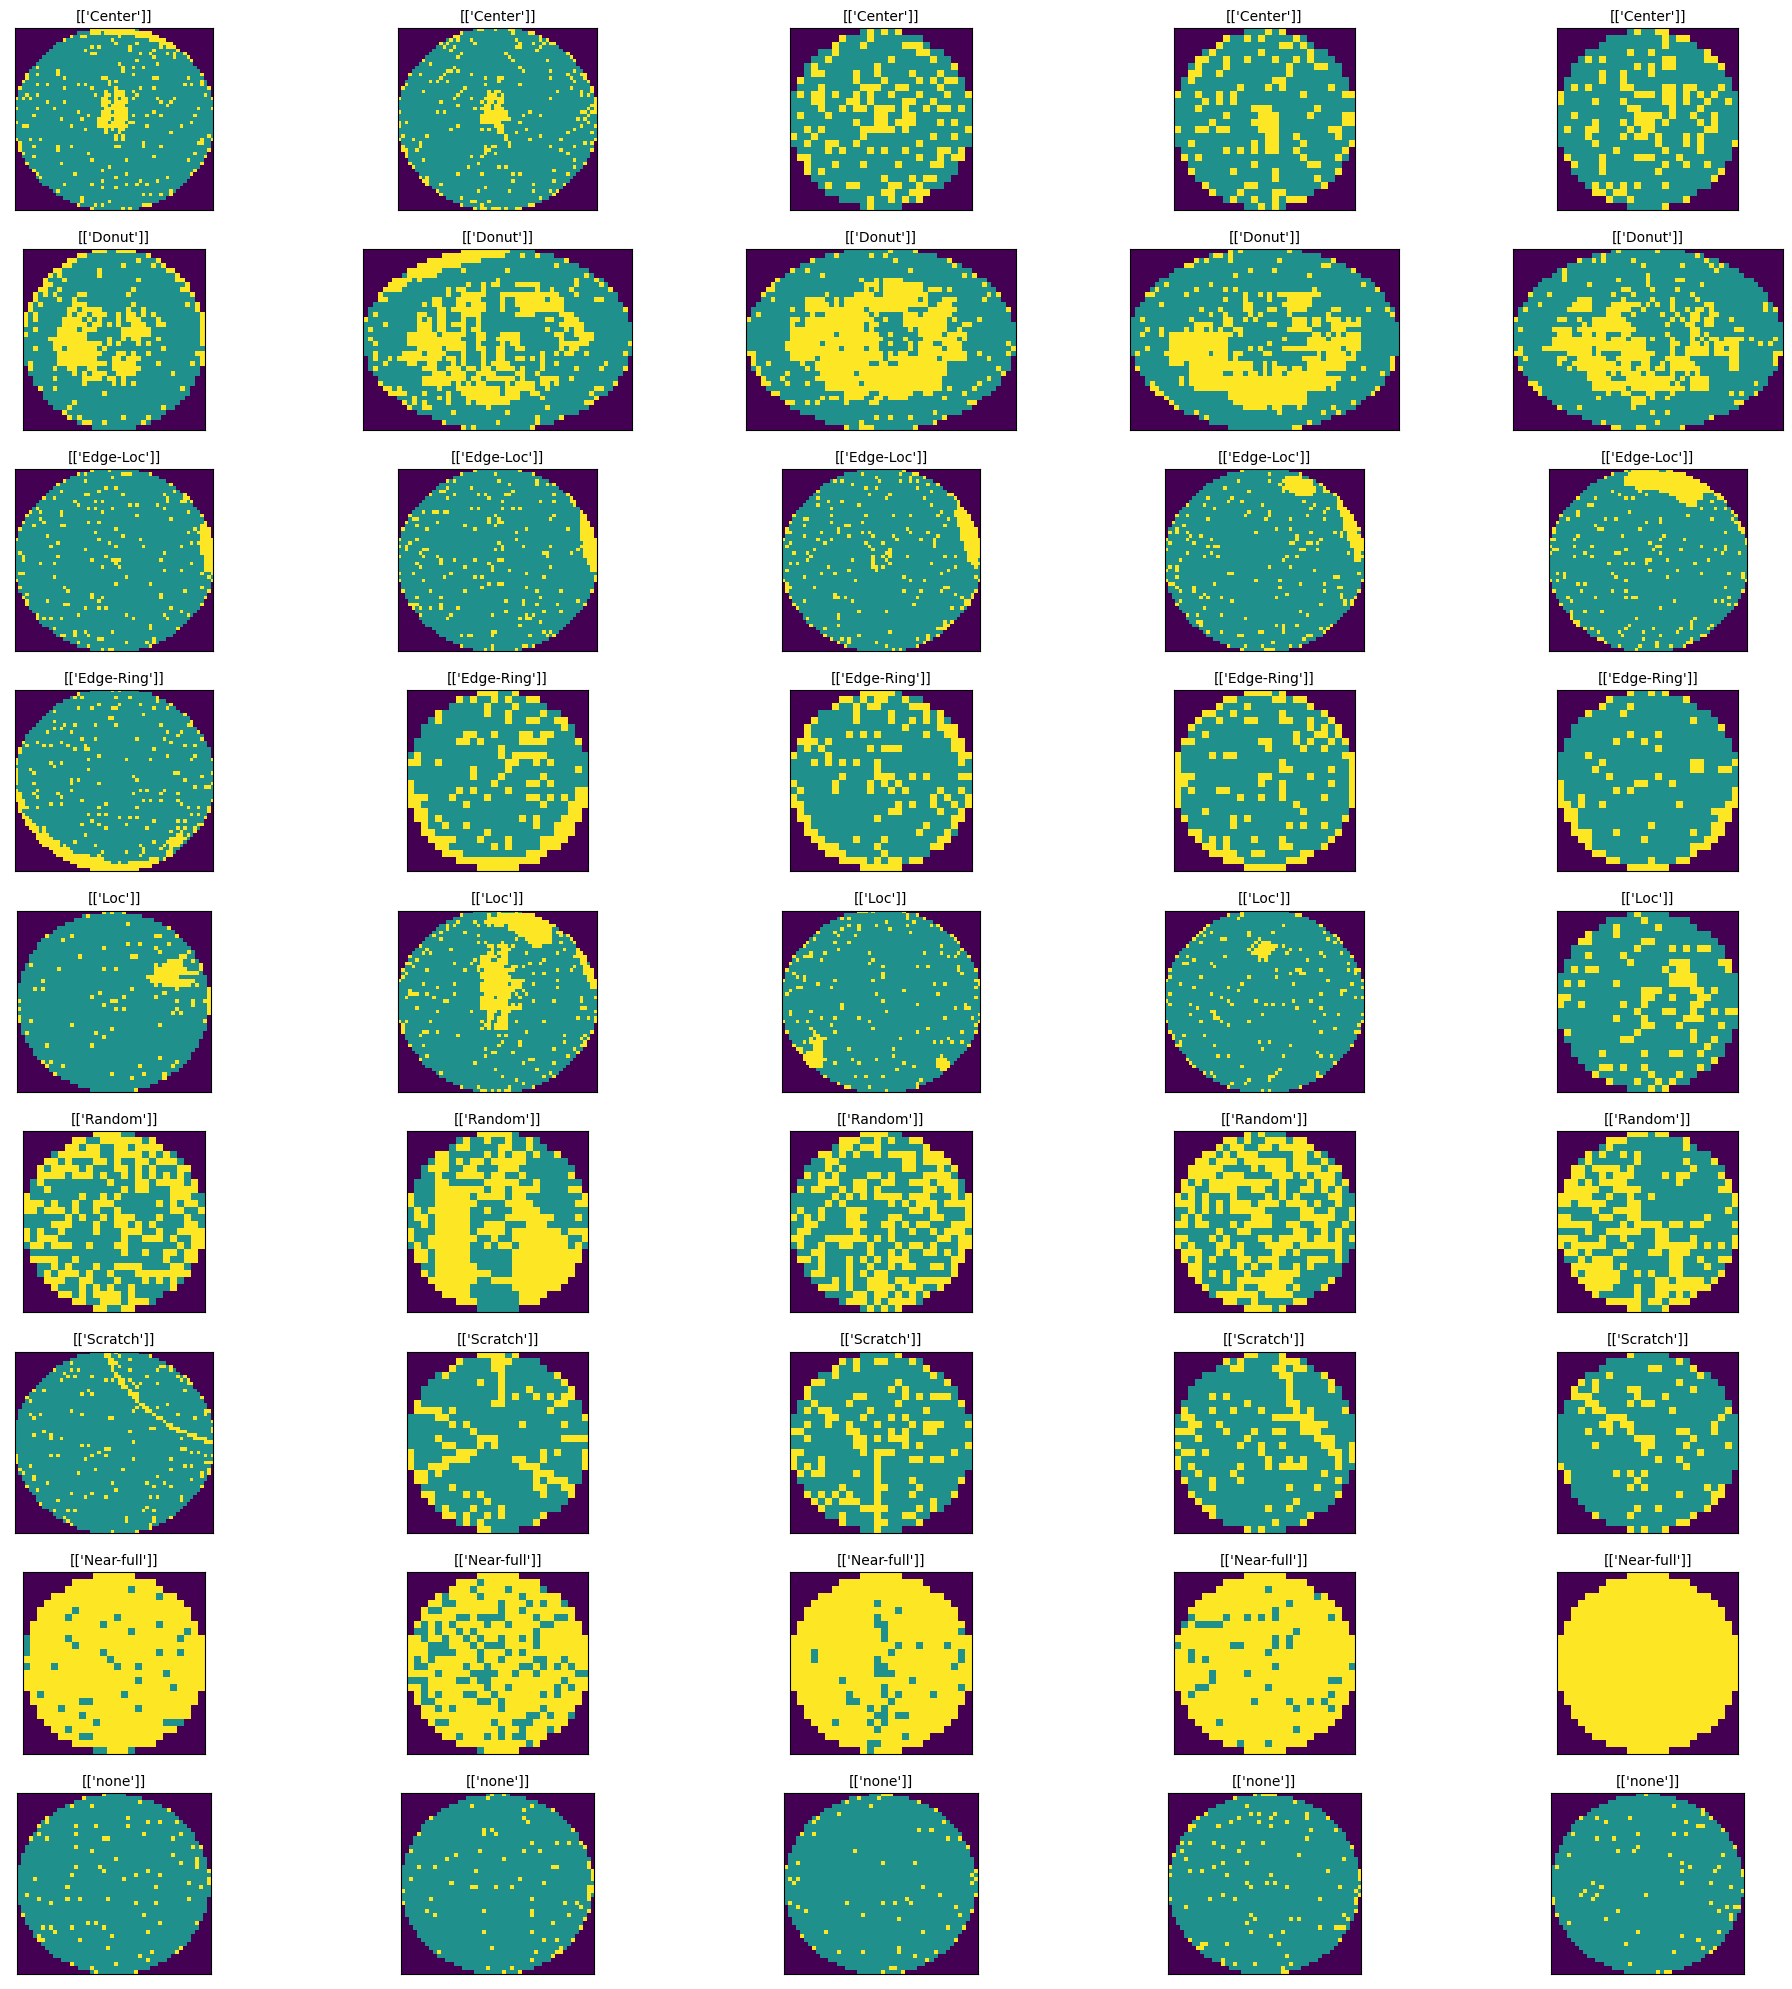

In [8]:
# plot several from each as an example
fig, ax = plt.subplots(nrows = 9, ncols = 5, figsize=(20, 20))
ax = ax.ravel(order='C')
for label_num, label in enumerate(MAPPING_TYPE):
    for i in range(5):
        img = dfs[label_num].waferMap.iloc[i]
        ax[label_num * 5 + i].imshow(img)
        ax[label_num * 5 + i].set_title(dfs[label_num].failureType.iloc[i], fontsize=10)
        ax[label_num * 5 + i].set_xticks([])
        ax[label_num * 5 + i].set_yticks([])
    plt.tight_layout()
plt.show() 

In [9]:
def process_wafer_map_to_image(wafer_map):
    # Normalize the wafer map to a range suitable for an image (0-255)
    wafer_map_normalized = ((np.array(wafer_map) + 1) **6 ).astype(np.uint8)
    image = Image.fromarray(wafer_map_normalized)

    # Resize the image to 64x64
    image = image.resize((64, 64))
    return image

def save_image_and_label(image, base_image_path, base_label_path, encoded_labels, class_id, idx):
    image.save(base_image_path)
    with open(base_label_path, 'w') as label_file:
        label_file.write(f"{class_id} 0.5 0.5 1.0 1.0\n")


def process_split(data, output_dir):
    images_dir = os.path.join(output_dir, "images")
    labels_dir = os.path.join(output_dir, "labels")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    idx_counter = 0 

    for _, row in data.iterrows():
        wafer_map = row['waferMap'] 
        encoded_labels = row['encoded_labels']

        image = process_wafer_map_to_image(wafer_map)  # Should return a PIL image
        
        base_image_path = os.path.join(images_dir, f"{encoded_labels}_{idx_counter}.png")
        base_label_path = os.path.join(labels_dir, f"{encoded_labels}_{idx_counter}.txt")
        save_image_and_label(image, base_image_path, base_label_path, encoded_labels, encoded_labels, idx_counter)
        idx_counter += 1

        # Process rotated and mirrored versions
        for rotation in [90, 180, 270]:
            rotated_image = image.rotate(rotation)
            rotated_image_path = os.path.join(images_dir, f"{encoded_labels}_{idx_counter}.png")
            rotated_label_path = os.path.join(labels_dir, f"{encoded_labels}_{idx_counter}.txt")
            save_image_and_label(rotated_image, rotated_image_path, rotated_label_path, encoded_labels, encoded_labels, idx_counter)
            idx_counter += 1

            mirrored_image = rotated_image.transpose(Image.FLIP_LEFT_RIGHT)
            mirrored_image_path = os.path.join(images_dir, f"{encoded_labels}_{idx_counter}.png")
            mirrored_label_path = os.path.join(labels_dir, f"{encoded_labels}_{idx_counter}.txt")
            save_image_and_label(mirrored_image, mirrored_image_path, mirrored_label_path, encoded_labels, encoded_labels, idx_counter)
            idx_counter += 1

        # Mirror the original image
        mirrored_image = image.transpose(Image.FLIP_LEFT_RIGHT)
        mirrored_image_path = os.path.join(images_dir, f"{encoded_labels}_{idx_counter}.png")
        mirrored_label_path = os.path.join(labels_dir, f"{encoded_labels}_{idx_counter}.txt")
        save_image_and_label(mirrored_image, mirrored_image_path, mirrored_label_path, encoded_labels, encoded_labels, idx_counter)
        idx_counter += 1

In [10]:
# Preprocess and save images to .png
for label_num, label in enumerate(MAPPING_TYPE):
    label_dir = os.path.join(DATSETS_DIR, str(label_num))
    
    # If directory exists, remove it and then create it
    if os.path.exists(label_dir):
        shutil.rmtree(label_dir) 
    
    os.makedirs(label_dir)
    process_split(dfs[label_num], label_dir)

print(f"Labeled Image folders made at: {DATSETS_DIR}")

Labeled Image folders made at: datasets/


In [11]:
# re-pickle each labeled dataset incase we want them later
for label_num, label in enumerate(MAPPING_TYPE):
    for i in range(5):
        dfs[label_num].to_pickle(f"{DATSETS_DIR}{label_num}/wafermap_{label_num}.pickle")

GAN to generate balanced dataset

I am using a WGAN-GP as I ran into stability issues training with using a DCGAN which couldn't handle the depth nessecary to capture more of the variability in the error patterns. The problem both are facing is that even with the data augmentation, there are just so few examples of some of the error patterns with large variance. Of special note is the scratch error pattern. This pattern is very very difficult to generate and detect, since it can have so many way of manifesting, and most infuriatingly, it tends to appear on top of a pattern that already appears very similar to another pattern, such as Loc, Edge-Loc, or none. More on architecture choice later.

In [12]:
MAPPING_TYPE = {'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3, 'Loc': 4, 'Random': 5, 'Scratch': 6, 'Near-full': 7, 'none': 8}
batch_size = 256

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None, classes=None, max_size=8000):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = classes
        self.image_paths = []
        self.labels = []

        for filename in os.listdir(self.data_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                class_label = int(filename.split('_')[0])  # Extract class from 'X_YYY.png'
                if class_label in classes:
                    self.image_paths.append(os.path.join(self.data_dir, filename))
                    self.labels.append(classes.index(class_label))  # Map to index

        self.shuffle_and_trim(max_size)

    def shuffle_and_trim(self, max_size):
        combined = list(zip(self.image_paths, self.labels))
        random.shuffle(combined)
        self.image_paths, self.labels = zip(*combined)

        self.image_paths = list(self.image_paths)
        self.labels = list(self.labels)

        if len(self.image_paths) > max_size:
            print(f"Dataset above max, trimming to:{max_size}")
            self.image_paths = self.image_paths[:max_size]
            self.labels = self.labels[:max_size]

        length = len(self.labels)
        num_to_trim = length % batch_size

        if num_to_trim > 0:
            print("Dataset not multiple of batch size, trimming")
            self.image_paths = self.image_paths[:-num_to_trim]
            self.labels = self.labels[:-num_to_trim]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path)

        image = image.resize((64, 64))

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def get_dataloaders(yaml_path, batch_size=256, num_workers=4, max_size=8000):
    classes = list(MAPPING_TYPE.values())
    datasets = []
    data_loaders = []

    for key, val in enumerate(MAPPING_TYPE):
        print(key,val)
        dataset = CustomDataset(
            data_dir=DATSETS_DIR + str(key) + '/images',
            transform=transform,
            classes=classes,
            max_size=max_size
        )
        datasets.append(dataset)
        data_loaders.append(DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers))

    return data_loaders, datasets


In [13]:
# Create custom datasets and dataloaders from processed images
data_loaders, datasets = get_dataloaders(OUTPUT_YAML_PATH, max_size=20000)

combined_dataset = ConcatDataset(datasets)
combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

0 Center
Dataset above max, trimming to:20000
Dataset not multiple of batch size, trimming
1 Donut
Dataset not multiple of batch size, trimming
2 Edge-Loc
Dataset above max, trimming to:20000
Dataset not multiple of batch size, trimming
3 Edge-Ring
Dataset above max, trimming to:20000
Dataset not multiple of batch size, trimming
4 Loc
Dataset above max, trimming to:20000
Dataset not multiple of batch size, trimming
5 Random
Dataset not multiple of batch size, trimming
6 Scratch
Dataset not multiple of batch size, trimming
7 Near-full
Dataset not multiple of batch size, trimming
8 none
Dataset above max, trimming to:20000
Dataset not multiple of batch size, trimming


Architecture

The generator is 3 resize-convolution blocks, followed by a transpose convolution and a final convolution layer essentially standing in for a max pool layer to sharpen the image. Initially, the generator was fully transpose convolutions, however this led to severe checkerboarding over the image, and thus they were switched out for resize convolution layers. An issue seen with fully resize-convolution based models is that output images tend to be a little fuzzy. This was problematic as there are ostensibly only 3 differnet possible values; not wafer, no defect, defect. To combat this, the last transpose convolution and convolution serve to both consolidate all the feature maps and trainably sharpen the output image.

The discriminator (or critic) is a more traditional CNN that uses layer normalization as recommended by the original WGAN-GP paper (anecdotally this makes a huge different, you can try swap it for spectral norm or batchnorm, but it will likely not train well)

Known Issues:

The output images are still not as sharp as they could be, this is likely partially due to the fuzziness introduced by all the resizing, however this is the compromise against the issue that the generated images wouldn't be the correct roundness. Its possible that adjusting generator kernel size could fix this, however that has not been fully attempted yet. The generator model is still not good enough to capture the variability of the of the base dataset, in particular it still faces the same issue DCGAN does against the scratch pattern. I'm still currently making adjustments to both architectures to hone in on the problem, since currently the discriminator tends to overpower the generator. 

Example of checkerboarding:

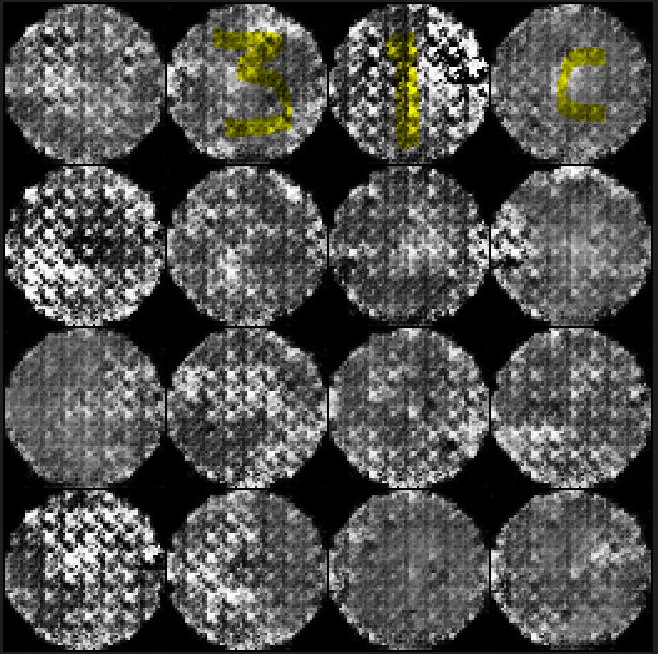





In [14]:
# WGAN-GP Architecture
LATENT_SPACE_DIM = 100  # Latent space dimension
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
img_shape = (1, 64, 64)

def get_gaussian_latent_batch(device, batch_size=256):
    return Tensor(torch.randn((batch_size, LATENT_SPACE_DIM), device=device))


class GeneratorNet(nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()

        self.init_size = img_shape[1] // 4
        self.fc = nn.Sequential(
            nn.Linear(LATENT_SPACE_DIM, 128 * self.init_size ** 2),
            nn.BatchNorm1d(128 * self.init_size ** 2),
            nn.ReLU(),
        )

        # Resize Convolutional Layers
        self.model = nn.Sequential(
            # Block 1
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Resize to 2x
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # Block 2
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Resize to 2x
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # Block 3
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, img_shape[0], kernel_size=2, stride=2, padding=0),
            nn.Tanh(),
        )

    def forward(self, z):
        img = self.fc(z)
        img = img.view(img.shape[0], 128, self.init_size, self.init_size)
        img = self.model(img)
        return img



class DiscriminatorNet(nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        self.init_size = img_shape[1] // 4
        self.model = nn.Sequential(
            nn.Conv2d(img_shape[0], 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.LayerNorm([32, img_shape[1] // 2, img_shape[2] // 2]),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.LayerNorm([64, img_shape[1] // 4, img_shape[2] // 4]),
            nn.Flatten(),
            nn.Linear(64 * (self.init_size ** 2), 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        validity = self.model(img)
        return validity


def get_optimizers(d_net, g_net):
    d_opt = Adam(d_net.parameters(), lr=0.00002, betas=(0.7, 0.99))
    g_opt = Adam(g_net.parameters(), lr=0.0002, betas=(0.7, 0.99))
    return d_opt, g_opt


In [15]:
# Model class for training, eval etc
class GANModel:
    def __init__(
        self,
        data_loader,  
        num_epochs,
        batch_size=256,
        ref_batch_size=16,
        lambda_gp=10,
        n_critic=5,
        console_log_freq=1000,
        debug_imagery_log_freq=1000,
        checkpoint_freq=50,
        name="no_name",
        log=True,
    ):
        self.data_loader = data_loader
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.ref_batch_size = ref_batch_size
        self.lambda_gp = lambda_gp
        self.n_critic = n_critic

        self.console_log_freq = console_log_freq
        self.debug_imagery_log_freq = debug_imagery_log_freq
        self.checkpoint_freq = checkpoint_freq
        self.name = name
        self.log = log

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device_str = "cuda" if torch.cuda.is_available() else "cpu"

        self.d_net = DiscriminatorNet().train().to(self.device)
        self.g_net = GeneratorNet().train().to(self.device)
        self.d_opt, self.g_opt = get_optimizers(self.d_net, self.g_net)

        self.ref_noise_batch = get_gaussian_latent_batch(
            batch_size=ref_batch_size, device=self.device_str
        )

        self.img_cnt = 0
        self.discriminator_loss_values = []
        self.generator_loss_values = []

        self.writer = SummaryWriter() if log else None

        self.ts = time.time()

    def train(self):
        for epoch in range(self.num_epochs):
            if self.log:
                print(f"Starting Epoch: {epoch + 1} | time elapsed = {time.time() - self.ts:.2f} [s]")

            for batch_idx, (images, _) in enumerate(self.data_loader):
                real_images = images.type(Tensor)
    
                self.d_opt.zero_grad()
                
                z = get_gaussian_latent_batch(batch_size=images.shape[0], device=self.device_str)
                fake_images = self.g_net(z)

                real_validity = self.d_net(real_images)
                fake_validity = self.d_net(fake_images)
                gradient_penalty = self._compute_gradient_penalty(real_images, fake_images)

                d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + self.lambda_gp * gradient_penalty
                d_loss.backward()

                self.d_opt.step()
                
                if batch_idx % self.n_critic == 0:
                    self.g_opt.zero_grad()
                    fake_images = self.g_net(z)
                    fake_validity = self.d_net(fake_images)
                    g_loss = -torch.mean(fake_validity)
                    
                    g_loss.backward()
                    self.g_opt.step()

                    self._log_loss(d_loss, g_loss, epoch, batch_idx)

                if batch_idx % self.debug_imagery_log_freq == 0:
                    self._save_generated_images(epoch, batch_idx)

                if (epoch + 1) % self.checkpoint_freq == 0 and batch_idx == 0:
                    self._save_checkpoint(epoch, batch_idx)

            self._save_loss_graph(epoch)

    def _compute_gradient_penalty(self, real_samples, fake_samples):
        alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))

        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        d_interpolates = self.d_net(interpolates)
        fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)

        gradients = autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        return ((gradients_norm - 1) ** 2).mean()

    def _clip_weights(self, clip_value=.01):
        for param in self.d_net.parameters():
            param.data.clamp_(-clip_value, clip_value)

    def _get_real_labels(self):
        return torch.full((self.batch_size, 1), 0.9 , device=self.device)

    def _get_fake_labels(self):
        return torch.full((self.batch_size, 1), 0.1, device=self.device)

    def eval(self, label="no_label", num_samples=8, save_images=False, output_dir="evaluation", show_images=True):
        self.g_net.eval()
        latent_vectors = get_gaussian_latent_batch(batch_size=num_samples, device=self.device_str)

        with torch.no_grad():
            generated_images = self.g_net(latent_vectors)

        grid = vutils.make_grid(generated_images, nrow=int(num_samples**0.5), normalize=True, padding=2)

        if save_images:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)

            for idx, img in enumerate(generated_images):
                individual_img_path = os.path.join(output_dir, f"{label}_{idx + 1}.png")
                vutils.save_image(img, individual_img_path, normalize=True)

        if show_images:
            plt.figure(figsize=(8, 8))
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis("off")
            plt.title("Generated Images")
            plt.show()

    def _log_loss(self, discriminator_loss, generator_loss, epoch, batch_idx):
        if (batch_idx % self.console_log_freq == 0) and self.log:
            elapsed_time = time.time() - self.ts
            print(f'GAN training: time elapsed = {elapsed_time:.2f} [s] | epoch={epoch + 1} | batch= [{batch_idx + 1}/{len(self.data_loader)}]')
            print(f'Discriminator Loss = {discriminator_loss.item()} | Generator Loss = {generator_loss.item()}')
        self.discriminator_loss_values.append(discriminator_loss.item())
        self.generator_loss_values.append(generator_loss.item())

    def _save_generated_images(self, epoch, batch_idx):
        with torch.no_grad():
            if (batch_idx % self.console_log_freq == 0) and self.log:
                if not os.path.exists(DEBUG_IMAGERY_PATH):
                    os.makedirs(DEBUG_IMAGERY_PATH)
                log_generated_images = self.g_net(self.ref_noise_batch)
                log_generated_images_resized = nn.Upsample(scale_factor=2.5, mode='nearest')(log_generated_images)
                out_path = os.path.join(DEBUG_IMAGERY_PATH, f'{str(self.img_cnt).zfill(6)}.jpg')
                out_recent_path = os.path.join(DEBUG_IMAGERY_PATH, 'recent.jpg')
                save_image(log_generated_images_resized, out_path, nrow=int(np.sqrt(self.ref_batch_size)), normalize=True)
                save_image(log_generated_images_resized, out_recent_path, nrow=int(np.sqrt(self.ref_batch_size)), normalize=True)
                self.img_cnt += 1

    def _save_checkpoint(self, epoch, batch_idx):
        if not os.path.exists(CHECKPOINTS_PATH):
            os.makedirs(CHECKPOINTS_PATH)
        
        ckpt_model_name = f"{self.name}_epoch_{epoch + 1}_batch_{batch_idx + 1}.pth"
        checkpoint_path = os.path.join(CHECKPOINTS_PATH, ckpt_model_name)
        
        checkpoint = {
            "generator_state_dict": self.g_net.state_dict(),
            "discriminator_state_dict": self.d_net.state_dict(),
            "g_net_state_dict": self.g_net.state_dict(),
            "g_opt_state_dict": self.g_opt.state_dict(),
            "epoch": epoch,
            "Dloss": self.discriminator_loss_values,
            "GLoss": self.generator_loss_values,
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")
    
    def load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        
        self.g_net.load_state_dict(checkpoint["generator_state_dict"])
        self.d_net.load_state_dict(checkpoint["discriminator_state_dict"])
        
        self.g_net.to(self.device).eval()  # Set generator to evaluation mode
        self.d_net.to(self.device).eval()  # Set discriminator to evaluation mode

        print(f"Checkpoint loaded from {checkpoint_path}")
        
        return checkpoint["epoch"], checkpoint["Dloss"], checkpoint["GLoss"]
    
    def _save_loss_graph(self, epoch):
        if not os.path.exists(GRAPHS_PATH):
            os.makedirs(GRAPHS_PATH)
        plt.figure(figsize=(10, 5))
        plt.plot(self.generator_loss_values, label='Generator Loss', color="orange")
        plt.plot(self.discriminator_loss_values, label='Discriminator Loss', color="blue")
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title(f'Losses over Epochs (Epoch {epoch + 1})')
        plt.legend()

        graph_path = os.path.join(GRAPHS_PATH, f'{self.name}_loss_graph.png')
        plt.savefig(graph_path)
        plt.close()

Training

In [ ]:
# Skip this if you are not training from scratch

# Create GANModel and start training
model = GANModel(num_epochs=50, n_critic=7, lambda_gp=10, name="general", data_loader=combined_dataloader, log=True)
model.train()
model.eval()

Starting Epoch: 1 | time elapsed = 0.00 [s]
GAN training: time elapsed = 1.10 [s] | epoch=1 | batch= [1/78]
Discriminator Loss = 3.256016492843628 | Generator Loss = -0.43649232387542725
Starting Epoch: 2 | time elapsed = 11.28 [s]
GAN training: time elapsed = 11.56 [s] | epoch=2 | batch= [1/78]
Discriminator Loss = 1.1134474277496338 | Generator Loss = -0.4153091311454773
Starting Epoch: 3 | time elapsed = 21.81 [s]
GAN training: time elapsed = 22.46 [s] | epoch=3 | batch= [1/78]
Discriminator Loss = 0.33508092164993286 | Generator Loss = -0.41584813594818115
Starting Epoch: 4 | time elapsed = 32.95 [s]
GAN training: time elapsed = 33.23 [s] | epoch=4 | batch= [1/78]
Discriminator Loss = 0.06909430027008057 | Generator Loss = -0.38323119282722473
Starting Epoch: 5 | time elapsed = 43.27 [s]
GAN training: time elapsed = 43.53 [s] | epoch=5 | batch= [1/78]
Discriminator Loss = -0.045005738735198975 | Generator Loss = -0.3703792691230774
Starting Epoch: 6 | time elapsed = 53.72 [s]
GAN t

In [ ]:
# Create GANModel and start transfer learning
path_to_checkpoint = 'models/checkpoints/general_epoch_50_batch_1.pth'

for key, val in enumerate(MAPPING_TYPE):
    print(key, val)
    name = "class_" + str(key)
    model = GANModel(num_epochs=100, n_critic=5, lambda_gp=10, name=name, data_loader=data_loaders[key], log=True)
    model.load_checkpoint(path_to_checkpoint)
    model.train()
    model.eval()

In [ ]:
# Configuration
train_split = 0.6
val_split = 0.2
test_split = 0.2
assert train_split + val_split + test_split == 1.0, "Splits must sum up to 1."

In [ ]:
# Create GANModel and generate augmented dataset
num_samples_per_label= 5000

for key, val in enumerate(MAPPING_TYPE):
    print(key, val)
    name = "class" + str(key)
    model = GANModel(num_epochs=1, name=name, data_loader=data_loaders[key], log=False)
    model.load_checkpoint(f'best/class_{key}.pth')
    dir = DATSETS_DIR + str(key) + "/generated_images"
    num_samples = num_samples_per_label - int(failure_counts[key] * train_split) # to account for train test val split later
    if num_samples > 0:
        print("Generating " + str(num_samples) + " samples")
        model.eval(label=str(key), num_samples=num_samples, save_images=True, output_dir=dir)
        print("Saved generated images to: " + dir)
    else: 
        print("Skipping " + str(key) + ", already enough samples")

Prep enhanced dataset for yolo

In [ ]:
def collect_images(source_dir):
    valid_dirs = glob(os.path.join(source_dir, "[0-8]"), recursive=False)

    real_image_paths = []
    fake_image_paths = []

    for valid_dir in valid_dirs:
        real_images = glob(os.path.join(valid_dir, "images", "*.png"), recursive=True)
        fake_images = glob(os.path.join(valid_dir, "generated_images", "*.png"), recursive=True)
        real_image_paths.extend(real_images)
        fake_image_paths.extend(fake_images)

    real_images = []
    fake_images = []

    # Process real images
    for path in real_image_paths:
        label = os.path.basename(path).split("_")[0]
        if label.isdigit() and 0 <= int(label) <= 8:
            real_images.append((int(label), path))

    # Process fake images
    for path in fake_image_paths:
        label = os.path.basename(path).split("_")[0]
        if label.isdigit() and 0 <= int(label) <= 8:
            fake_images.append((int(label), path))

    return real_images, fake_images

def save_split(splits, destination_dir):
    for split, paths in splits.items():
        image_dir = os.path.join(destination_dir, split, "images")
        label_dir = os.path.join(destination_dir, split, "labels")
        os.makedirs(image_dir, exist_ok=True)
        os.makedirs(label_dir, exist_ok=True)

        for path in paths:
            if not os.path.isfile(path):
                print(f"Warning: {path} does not exist or is not a file.")
                continue

            with Image.open(path) as img:
                img = img.resize((64, 64))  # Resize image to (64, 64)
                image_name = os.path.basename(path)
                img.save(os.path.join(image_dir, image_name))

            image_name = os.path.basename(path).split(".")[0]
            label_file = os.path.join(label_dir, f"{image_name}.txt")
            label = int(os.path.basename(path).split("_")[0])

            with open(label_file, "w") as f:
                f.write(f"{label} 0.5 0.5 1.0 1.0\n")  # Dummy bounding box centered at (0.5, 0.5)


In [ ]:
# Collect images and format for YOLO
real_images, fake_images = collect_images(DATSETS_DIR)

random.shuffle(real_images)
random.shuffle(fake_images)

labels, paths = zip(*real_images)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    paths, labels, test_size=(1 - train_split), stratify=labels, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=test_split / (test_split + val_split), stratify=temp_labels, random_state=42
)

fake_paths = [path for _, path in fake_images]
fake_labels = [label for label, _ in fake_images]
train_paths.extend(fake_paths)
train_labels.extend(fake_labels)

print("# Training Samples: " + str(len(train_paths)))
print("# Testing Samples: " + str(len(test_paths)))
print("# Validation Samples: " + str(len(val_paths)))

splits = {
    "train": train_paths,
    "val": val_paths,
    "test": test_paths,
}

yaml_data = {
    "path": YOLO_DIR,
    "train": "train",
    "val": "val",
    "test": "test",
    "nc": 9,  # Number of classes (0-8 inclusive)
    "names": CLASS_NAMES
}

save_split(splits, DATSETS_DIR + YOLO_DIR)

with open(OUTPUT_YAML_PATH, "w") as yaml_file:
    yaml.dump(yaml_data, yaml_file)

print(f"Dataset prepared for YOLO. Data and configuration saved to {DATSETS_DIR + YOLO_DIR}.")

YOLO

Currently just transfer learning with YOLOv11 to test the viability of the generated dataset, the current GAN architecture is struggling to produce results that improve YOLO's accuracy, hovering around 90%

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")
results = model.train(data=OUTPUT_YAML_PATH, epochs=50, imgsz=64)